In [1]:
import pandas as pd
from catboost import CatBoostClassifier
import optuna
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np
#%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_style('darkgrid')
sns.set_theme(rc={'figure.figsize':(8,5),'font.size':12, 'savefig.format':'pdf'})

In [2]:
#link to competition: https://www.kaggle.com/competitions/playground-series-s4e10
#nickname on Kaggle - tokdestr
train_df = pd.read_csv('playground-series-s4e10/train.csv', index_col=0)

In [3]:
train_df.sample(10)

person_age  person_income person_home_ownership  person_emp_length   
id                                                                          
14903          22          38000              MORTGAGE                5.0  \
49483          29          30000                  RENT                0.0   
5506           23          60000              MORTGAGE                5.0   
1447           23          38000                  RENT                0.0   
28345          21          40000                  RENT                5.0   
22916          26          78000                  RENT                6.0   
33868          28          42000                  RENT                3.0   
14812          46          82600                  RENT                1.0   
57274          32          60000                   OWN                9.0   
42053          22          54252              MORTGAGE                5.0   

           loan_intent loan_grade  loan_amnt  loan_int_rate   
id                                                            
14903         PERSONAL          C       4800          14.79  \
49483          MEDICAL          A       8000           9.32   
5506           VENTURE          B      12000           9.88   
1447          PERSONAL          C       1000          14.26   
28345         PERSONAL          B       4200          10.74   
22916        EDUCATION          D       3000          14.59   
33868          VENTURE          B      12325          12.21   
14812          VENTURE          B       6000           9.91   
57274  HOMEIMPROVEMENT          C      14400          13.35   
42053          MEDICAL          A       3500           6.39   

       loan_percent_income cb_person_default_on_file   
id                                                     
14903                 0.12                         N  \
49483                 0.27                         N   
5506                  0.20                         N   
1447                  0.03                         N   
28345                 0.10                         N   
22916                 0.04                         N   
33868                 0.29                         N   
14812                 0.07                         N   
57274                 0.24                         Y   
42053                 0.06                         N   

       cb_person_cred_hist_length  loan_status  
id                                              
14903                           3            0  
49483                           7            0  
5506                            2            0  
1447                            3            0  
28345                           2            0  
22916                           3            0  
33868                           5            0  
14812                          16            0  
57274                           9            0  
42053                           3            0

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


In [5]:
train_df.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [6]:
train_df.describe()

person_age  person_income  person_emp_length     loan_amnt   
count  58645.000000   5.864500e+04       58645.000000  58645.000000  \
mean      27.550857   6.404617e+04           4.701015   9217.556518   
std        6.033216   3.793111e+04           3.959784   5563.807384   
min       20.000000   4.200000e+03           0.000000    500.000000   
25%       23.000000   4.200000e+04           2.000000   5000.000000   
50%       26.000000   5.800000e+04           4.000000   8000.000000   
75%       30.000000   7.560000e+04           7.000000  12000.000000   
max      123.000000   1.900000e+06         123.000000  35000.000000   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length   
count   58645.000000         58645.000000                58645.000000  \
mean       10.677874             0.159238                    5.813556   
std         3.034697             0.091692                    4.029196   
min         5.420000             0.000000                    2.000000   
25%         7.880000             0.090000                    3.000000   
50%        10.750000             0.140000                    4.000000   
75%        12.990000             0.210000                    8.000000   
max        23.220000             0.830000                   30.000000   

        loan_status  
count  58645.000000  
mean       0.142382  
std        0.349445  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000

In [7]:
train_df.duplicated().sum()

0

In [8]:
train_df['person_home_ownership'].unique()

array(['RENT', 'OWN', 'MORTGAGE', 'OTHER'], dtype=object)

In [9]:
train_df['loan_grade'].unique()

array(['B', 'C', 'A', 'D', 'E', 'F', 'G'], dtype=object)

In [10]:
train_df['loan_intent'].unique()

array(['EDUCATION', 'MEDICAL', 'PERSONAL', 'VENTURE', 'DEBTCONSOLIDATION',
       'HOMEIMPROVEMENT'], dtype=object)

In [11]:
train_df['cb_person_default_on_file'].unique()

array(['N', 'Y'], dtype=object)

In [12]:
train_df['person_emp_length'].unique()

array([  0.,   6.,   8.,  14.,   2.,   9.,  11.,   5.,   1.,  13.,   3.,
        10.,  12.,   4.,   7.,  21.,  17.,  16.,  18.,  19.,  15.,  20.,
        23.,  24.,  26.,  22.,  25.,  41.,  27.,  28.,  35.,  29.,  30.,
        31., 123.,  39.])

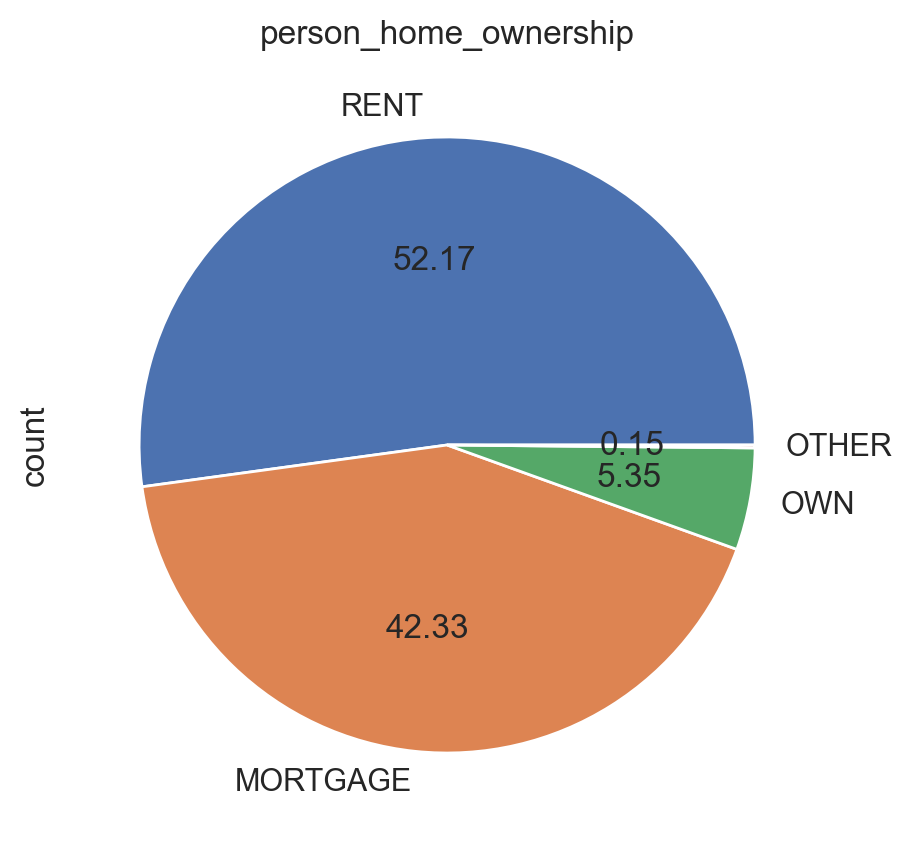

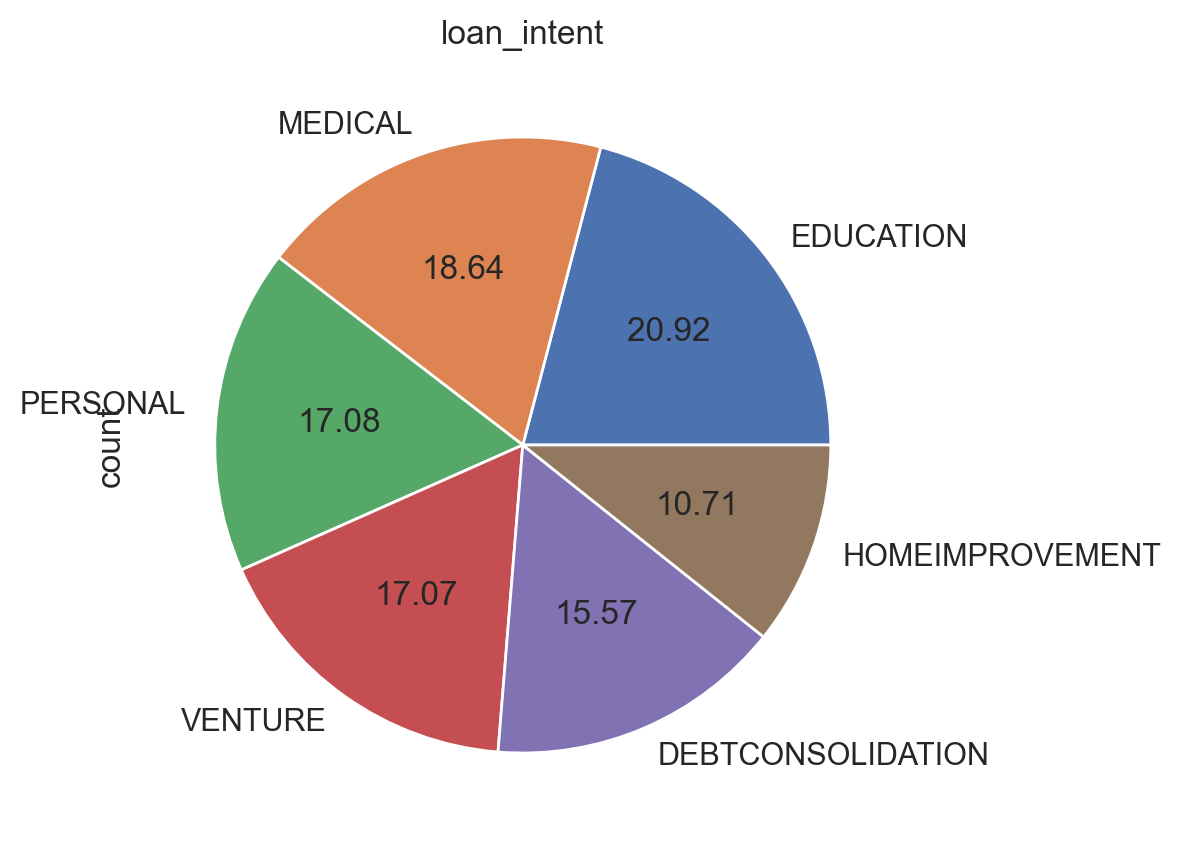

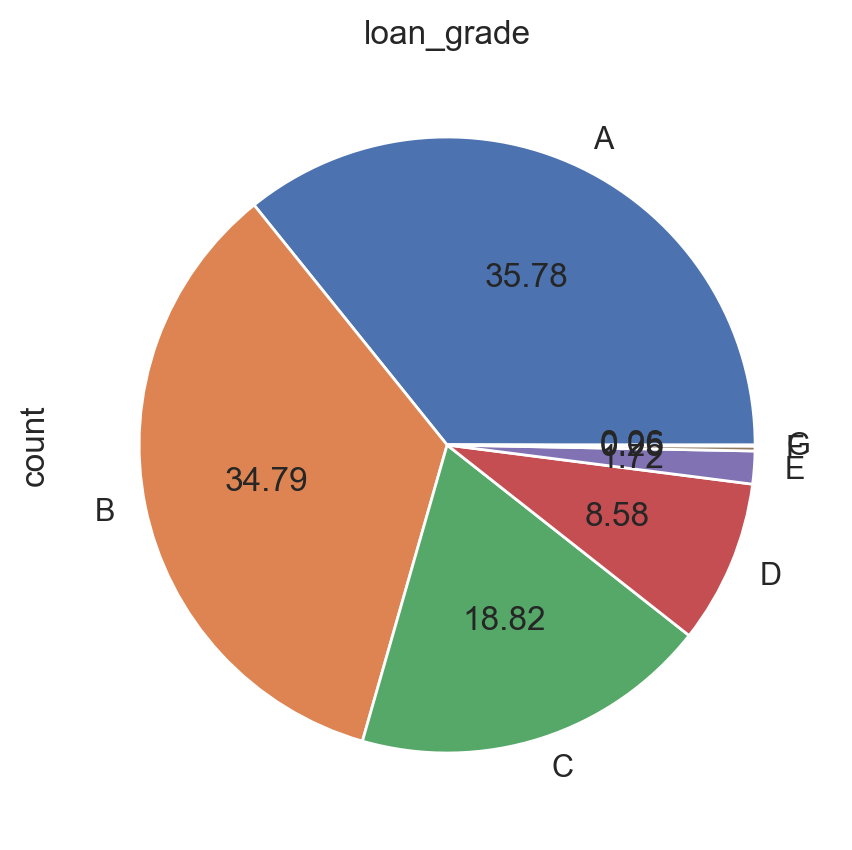

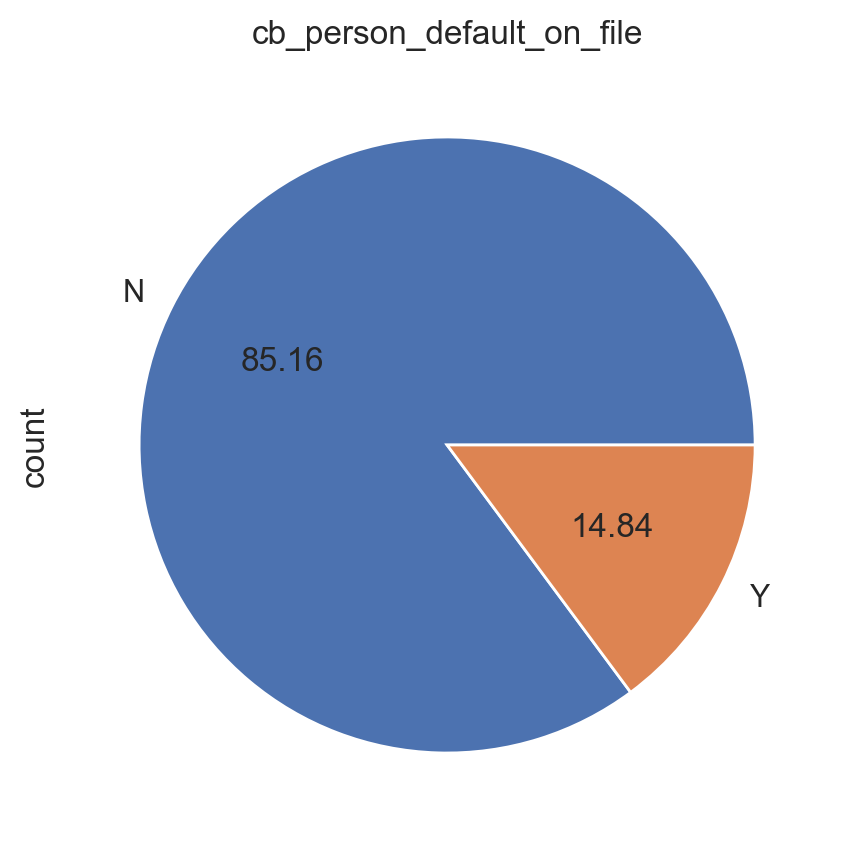

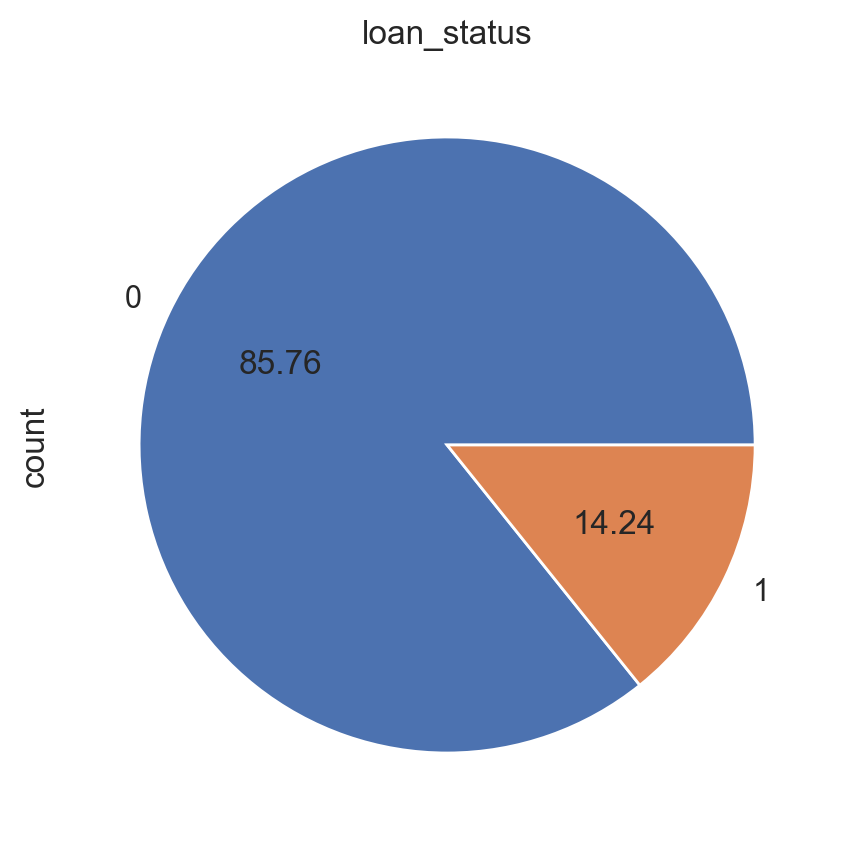

In [13]:
pie_columns = ['person_home_ownership','loan_intent', 'loan_grade', 'cb_person_default_on_file', 'loan_status']
for column in pie_columns:
    pie_df = train_df[column].value_counts()
    axes = pie_df.plot.pie(autopct='%.2f')
    plt.title(column)
    plt.show()

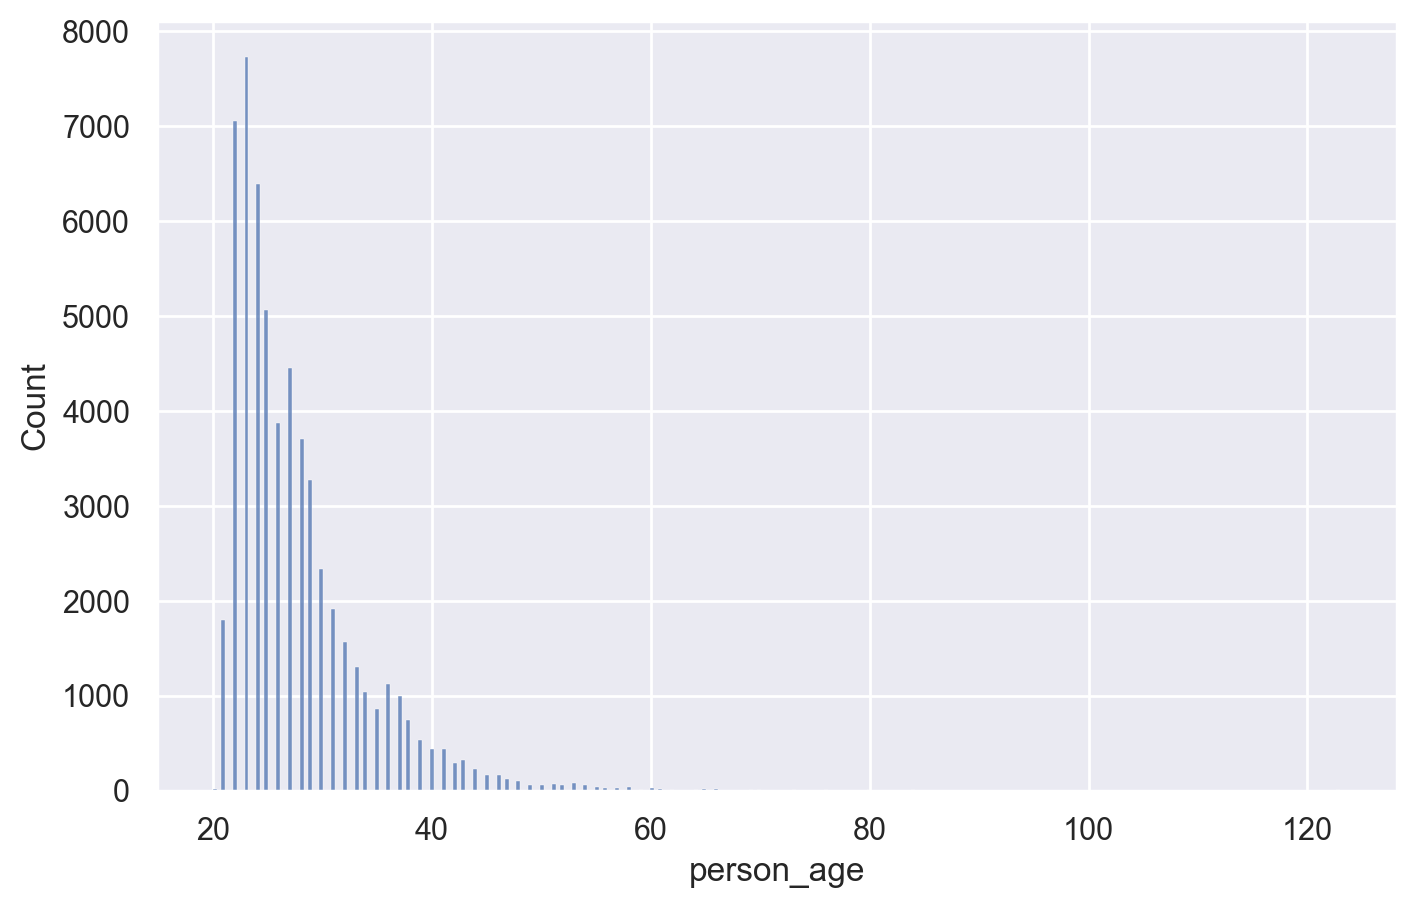

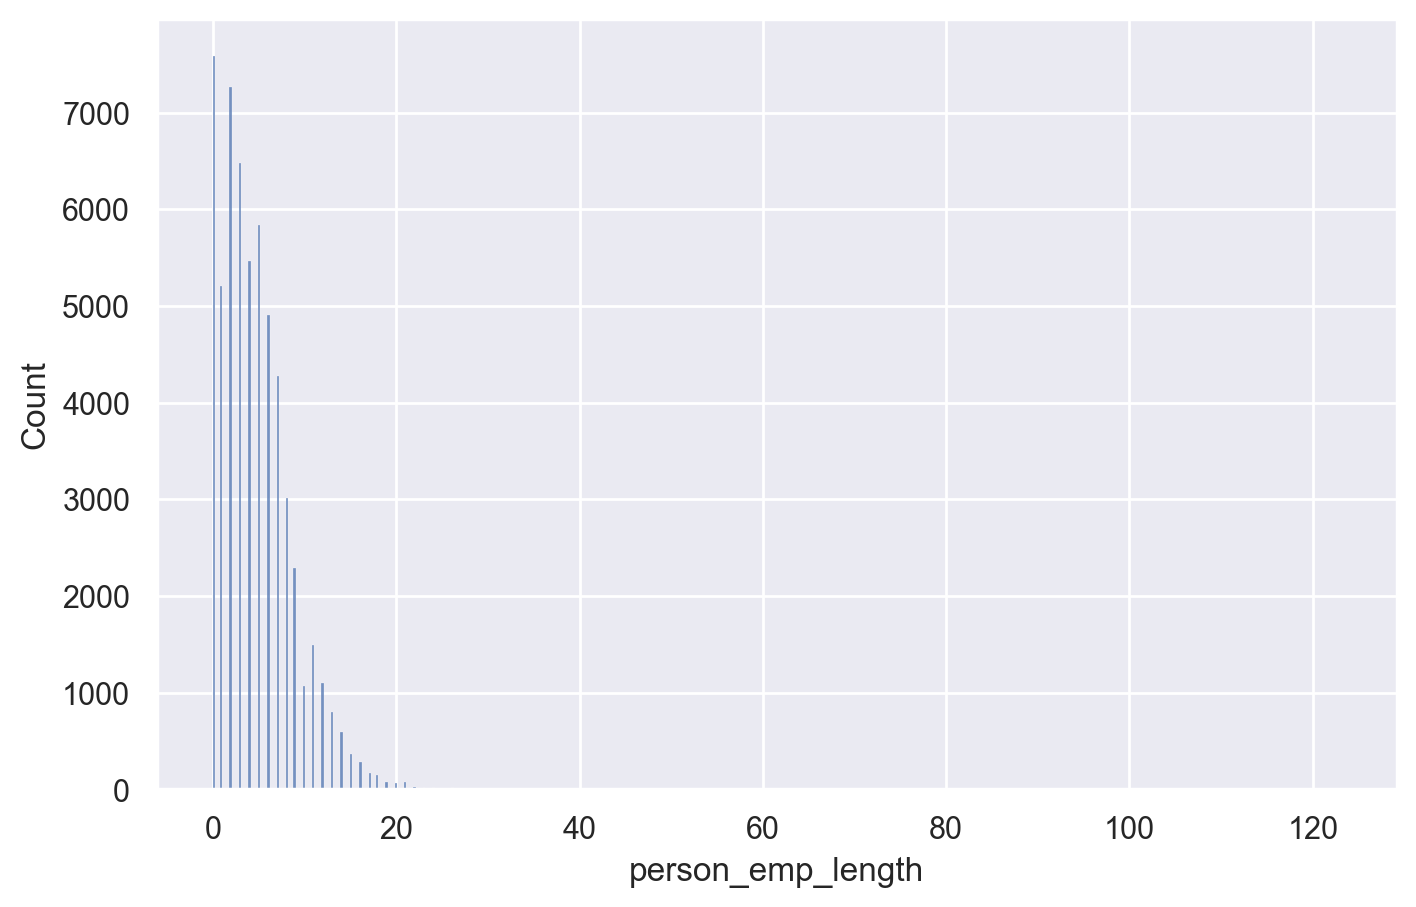

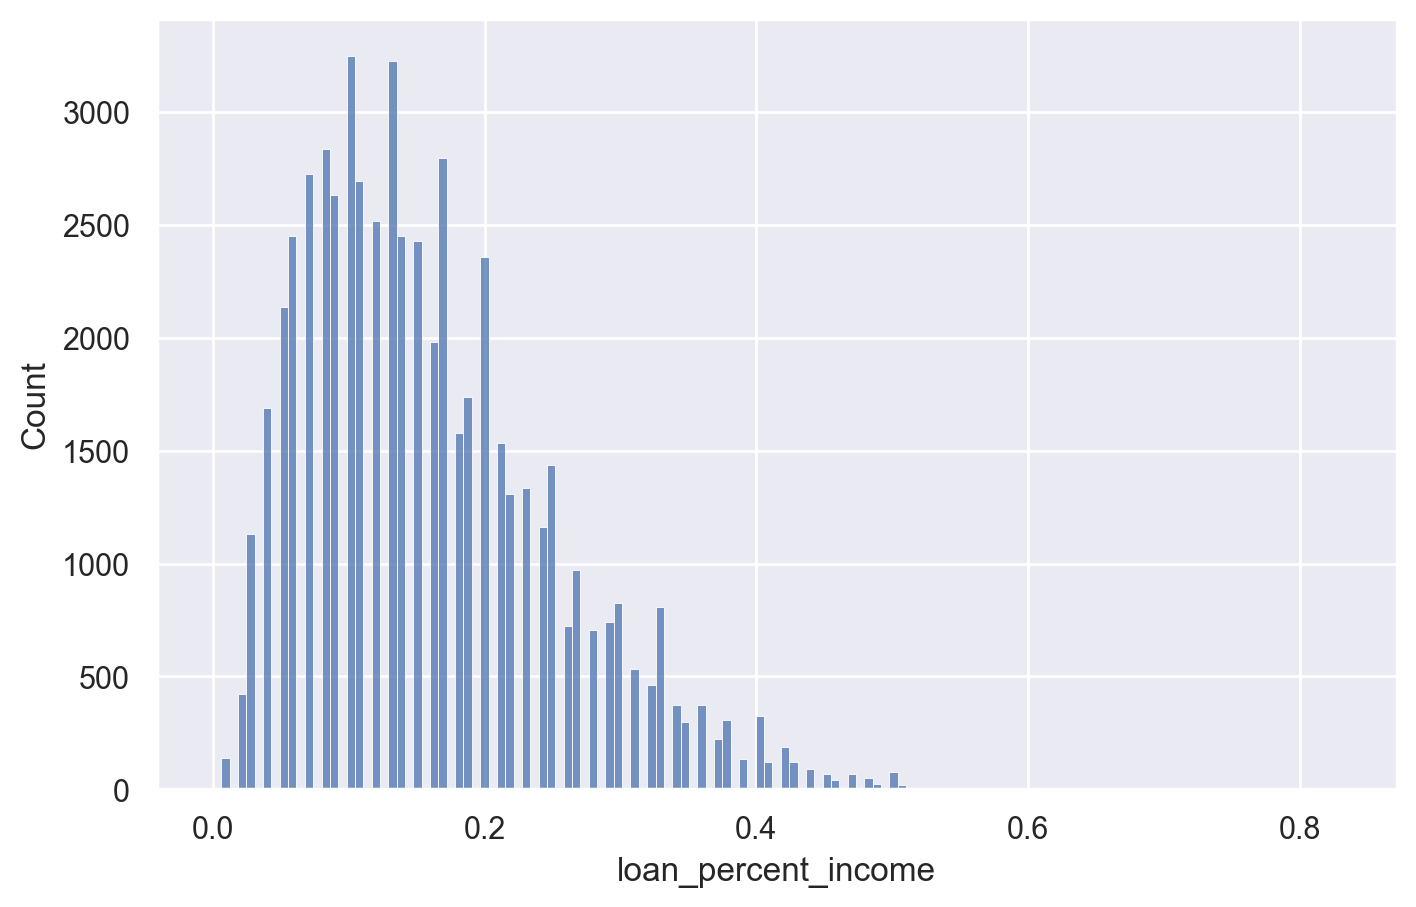

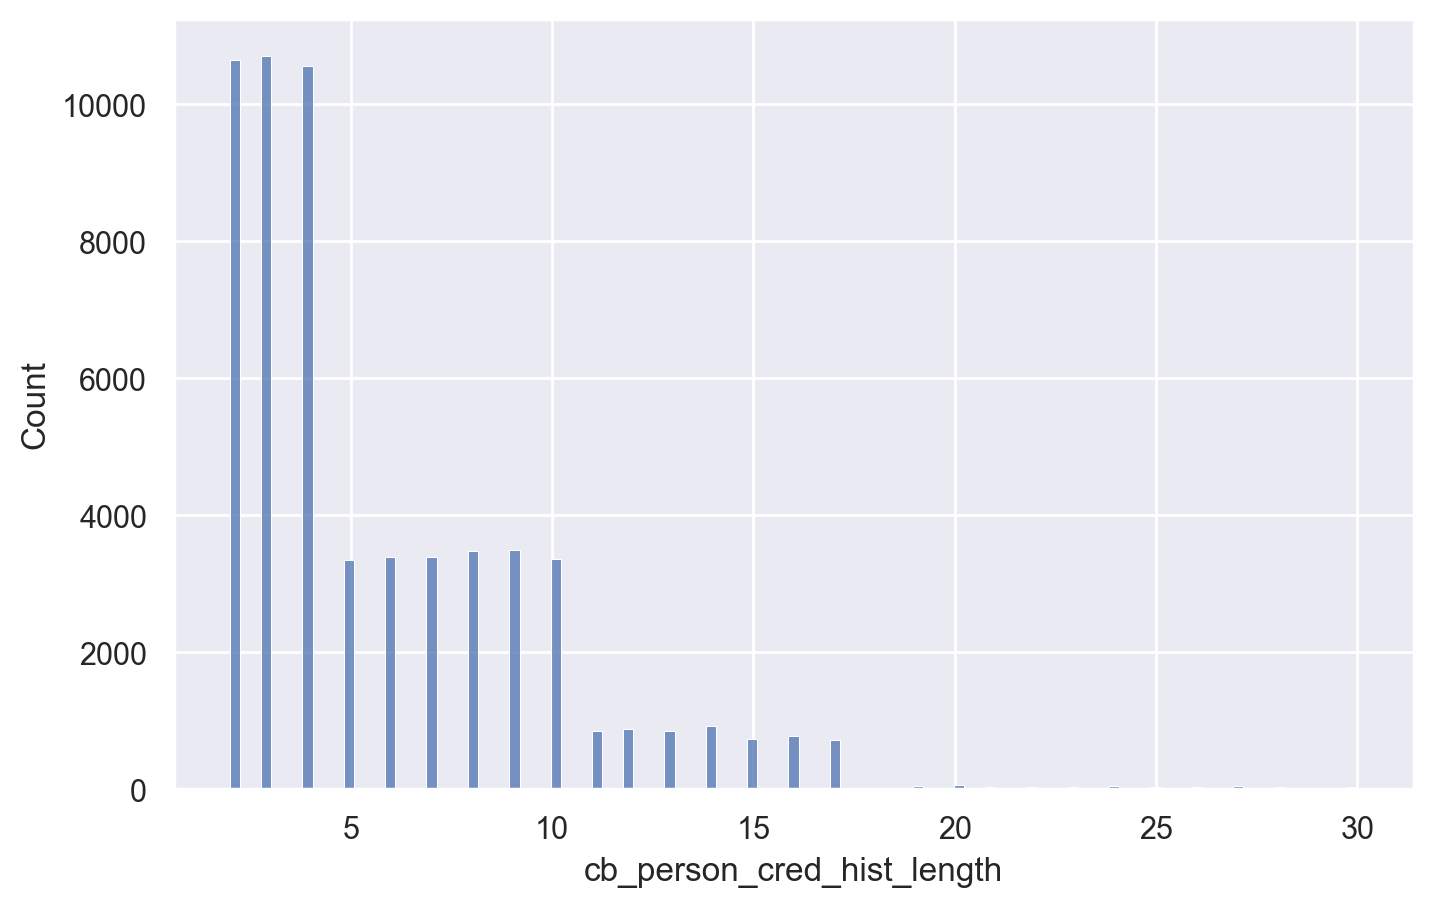

In [14]:
bar_columns = ['person_age', 'person_emp_length', 'loan_percent_income', 'cb_person_cred_hist_length']
for column in bar_columns:
    sns.histplot(data=train_df, x=column)
    plt.show()

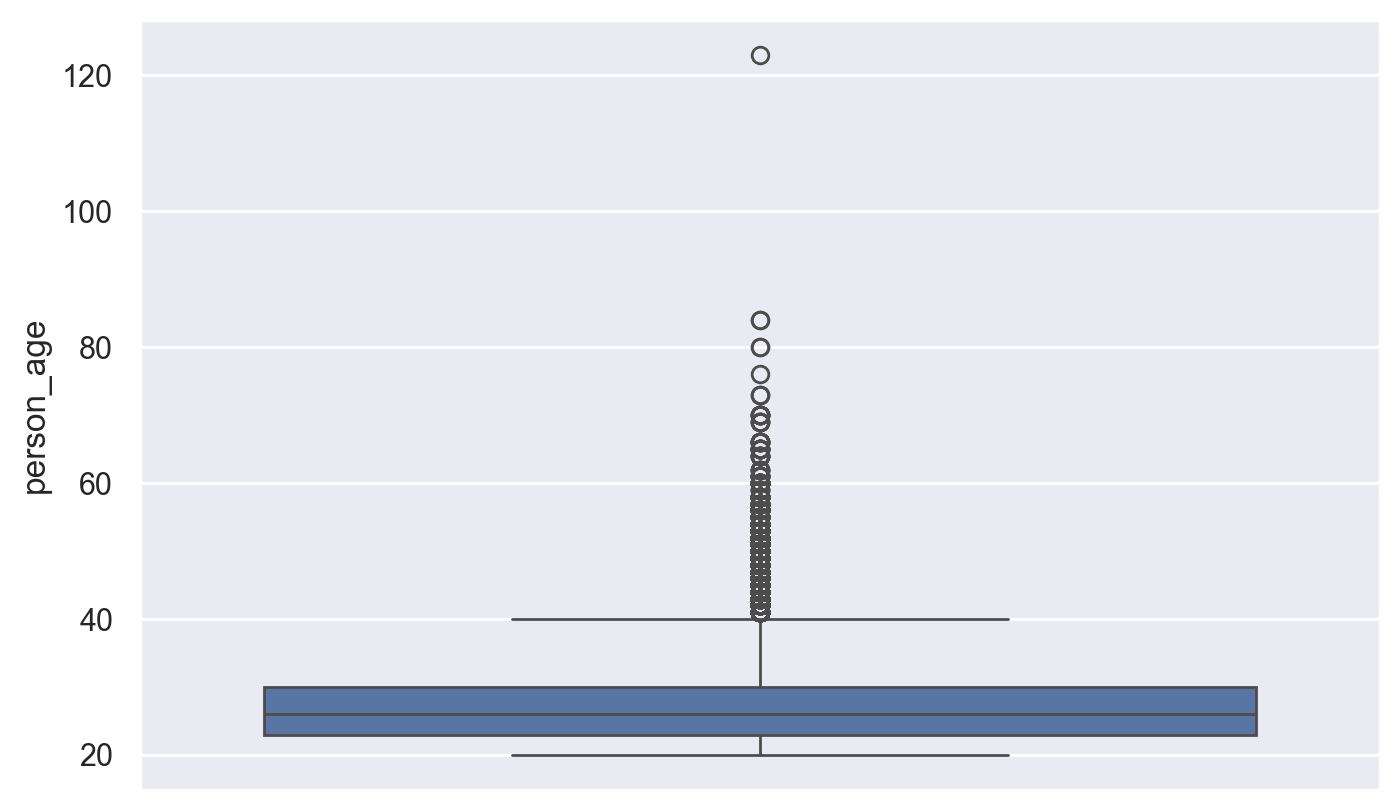

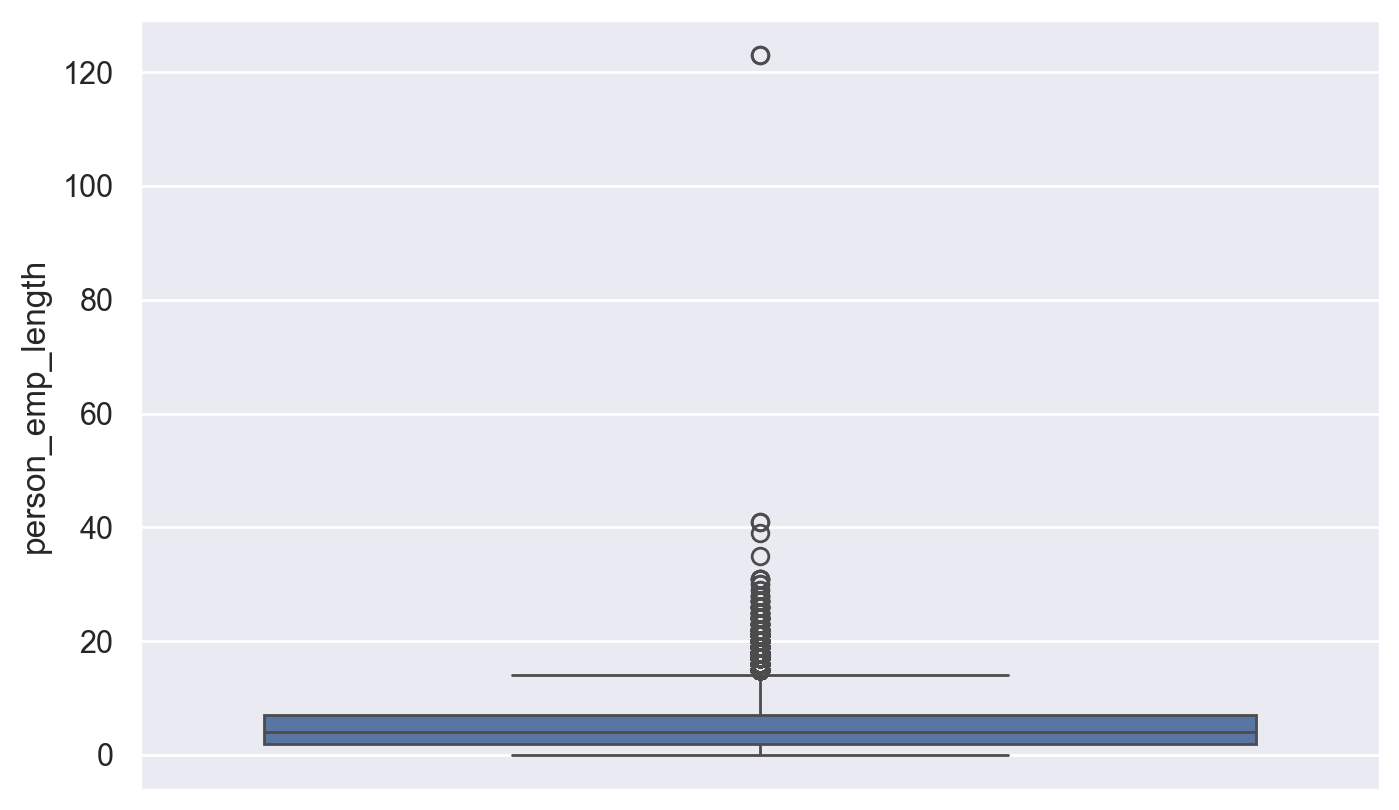

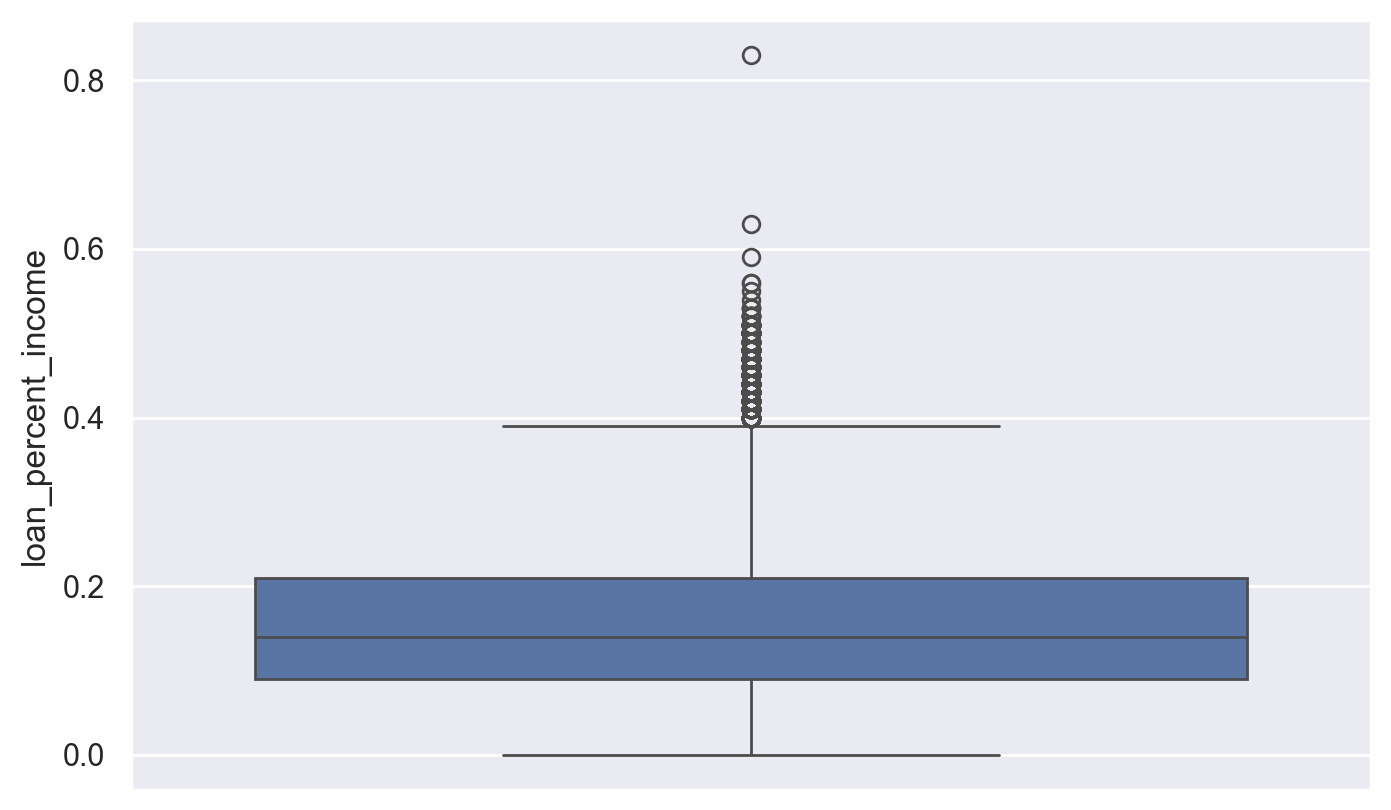

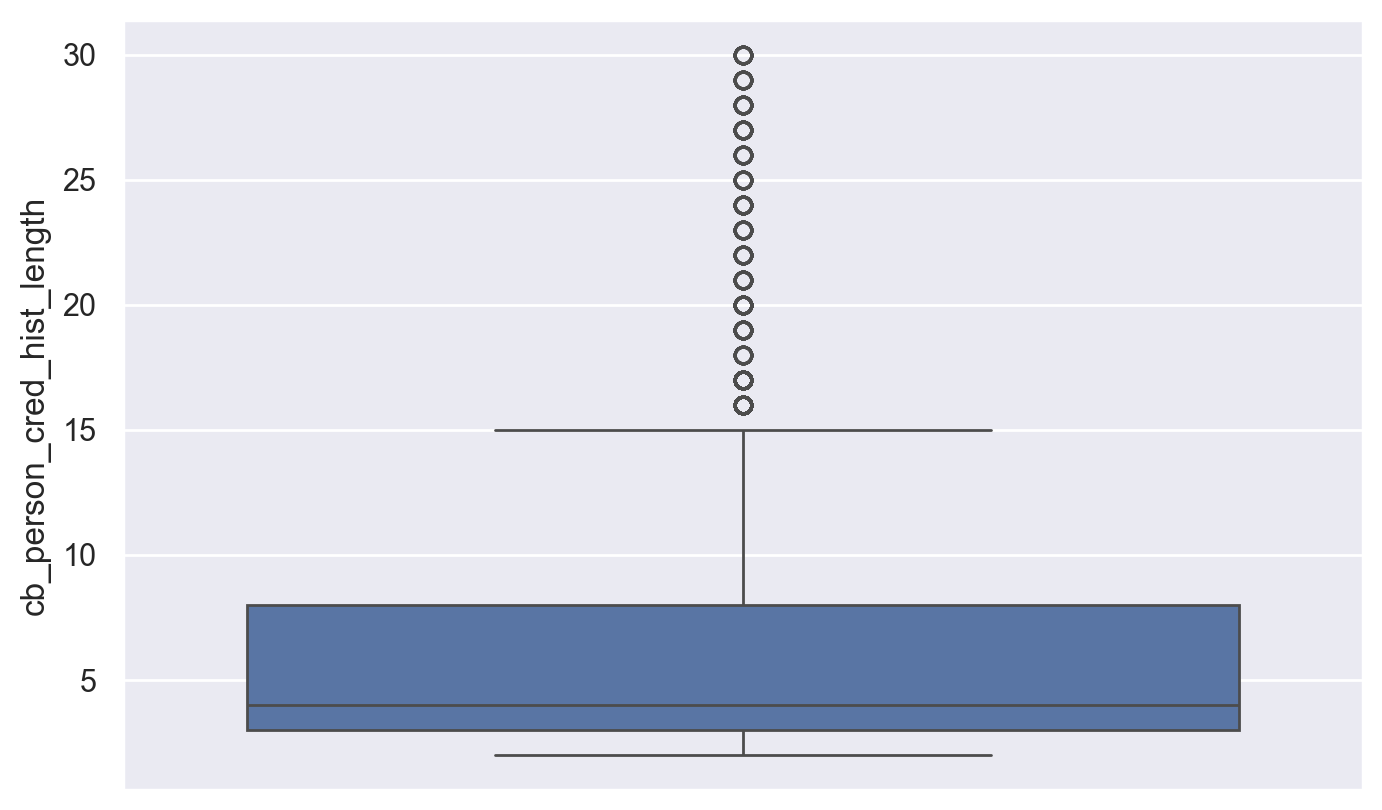

In [15]:
for column in bar_columns:
    sns.boxplot(data=train_df, y=column)
    plt.show()

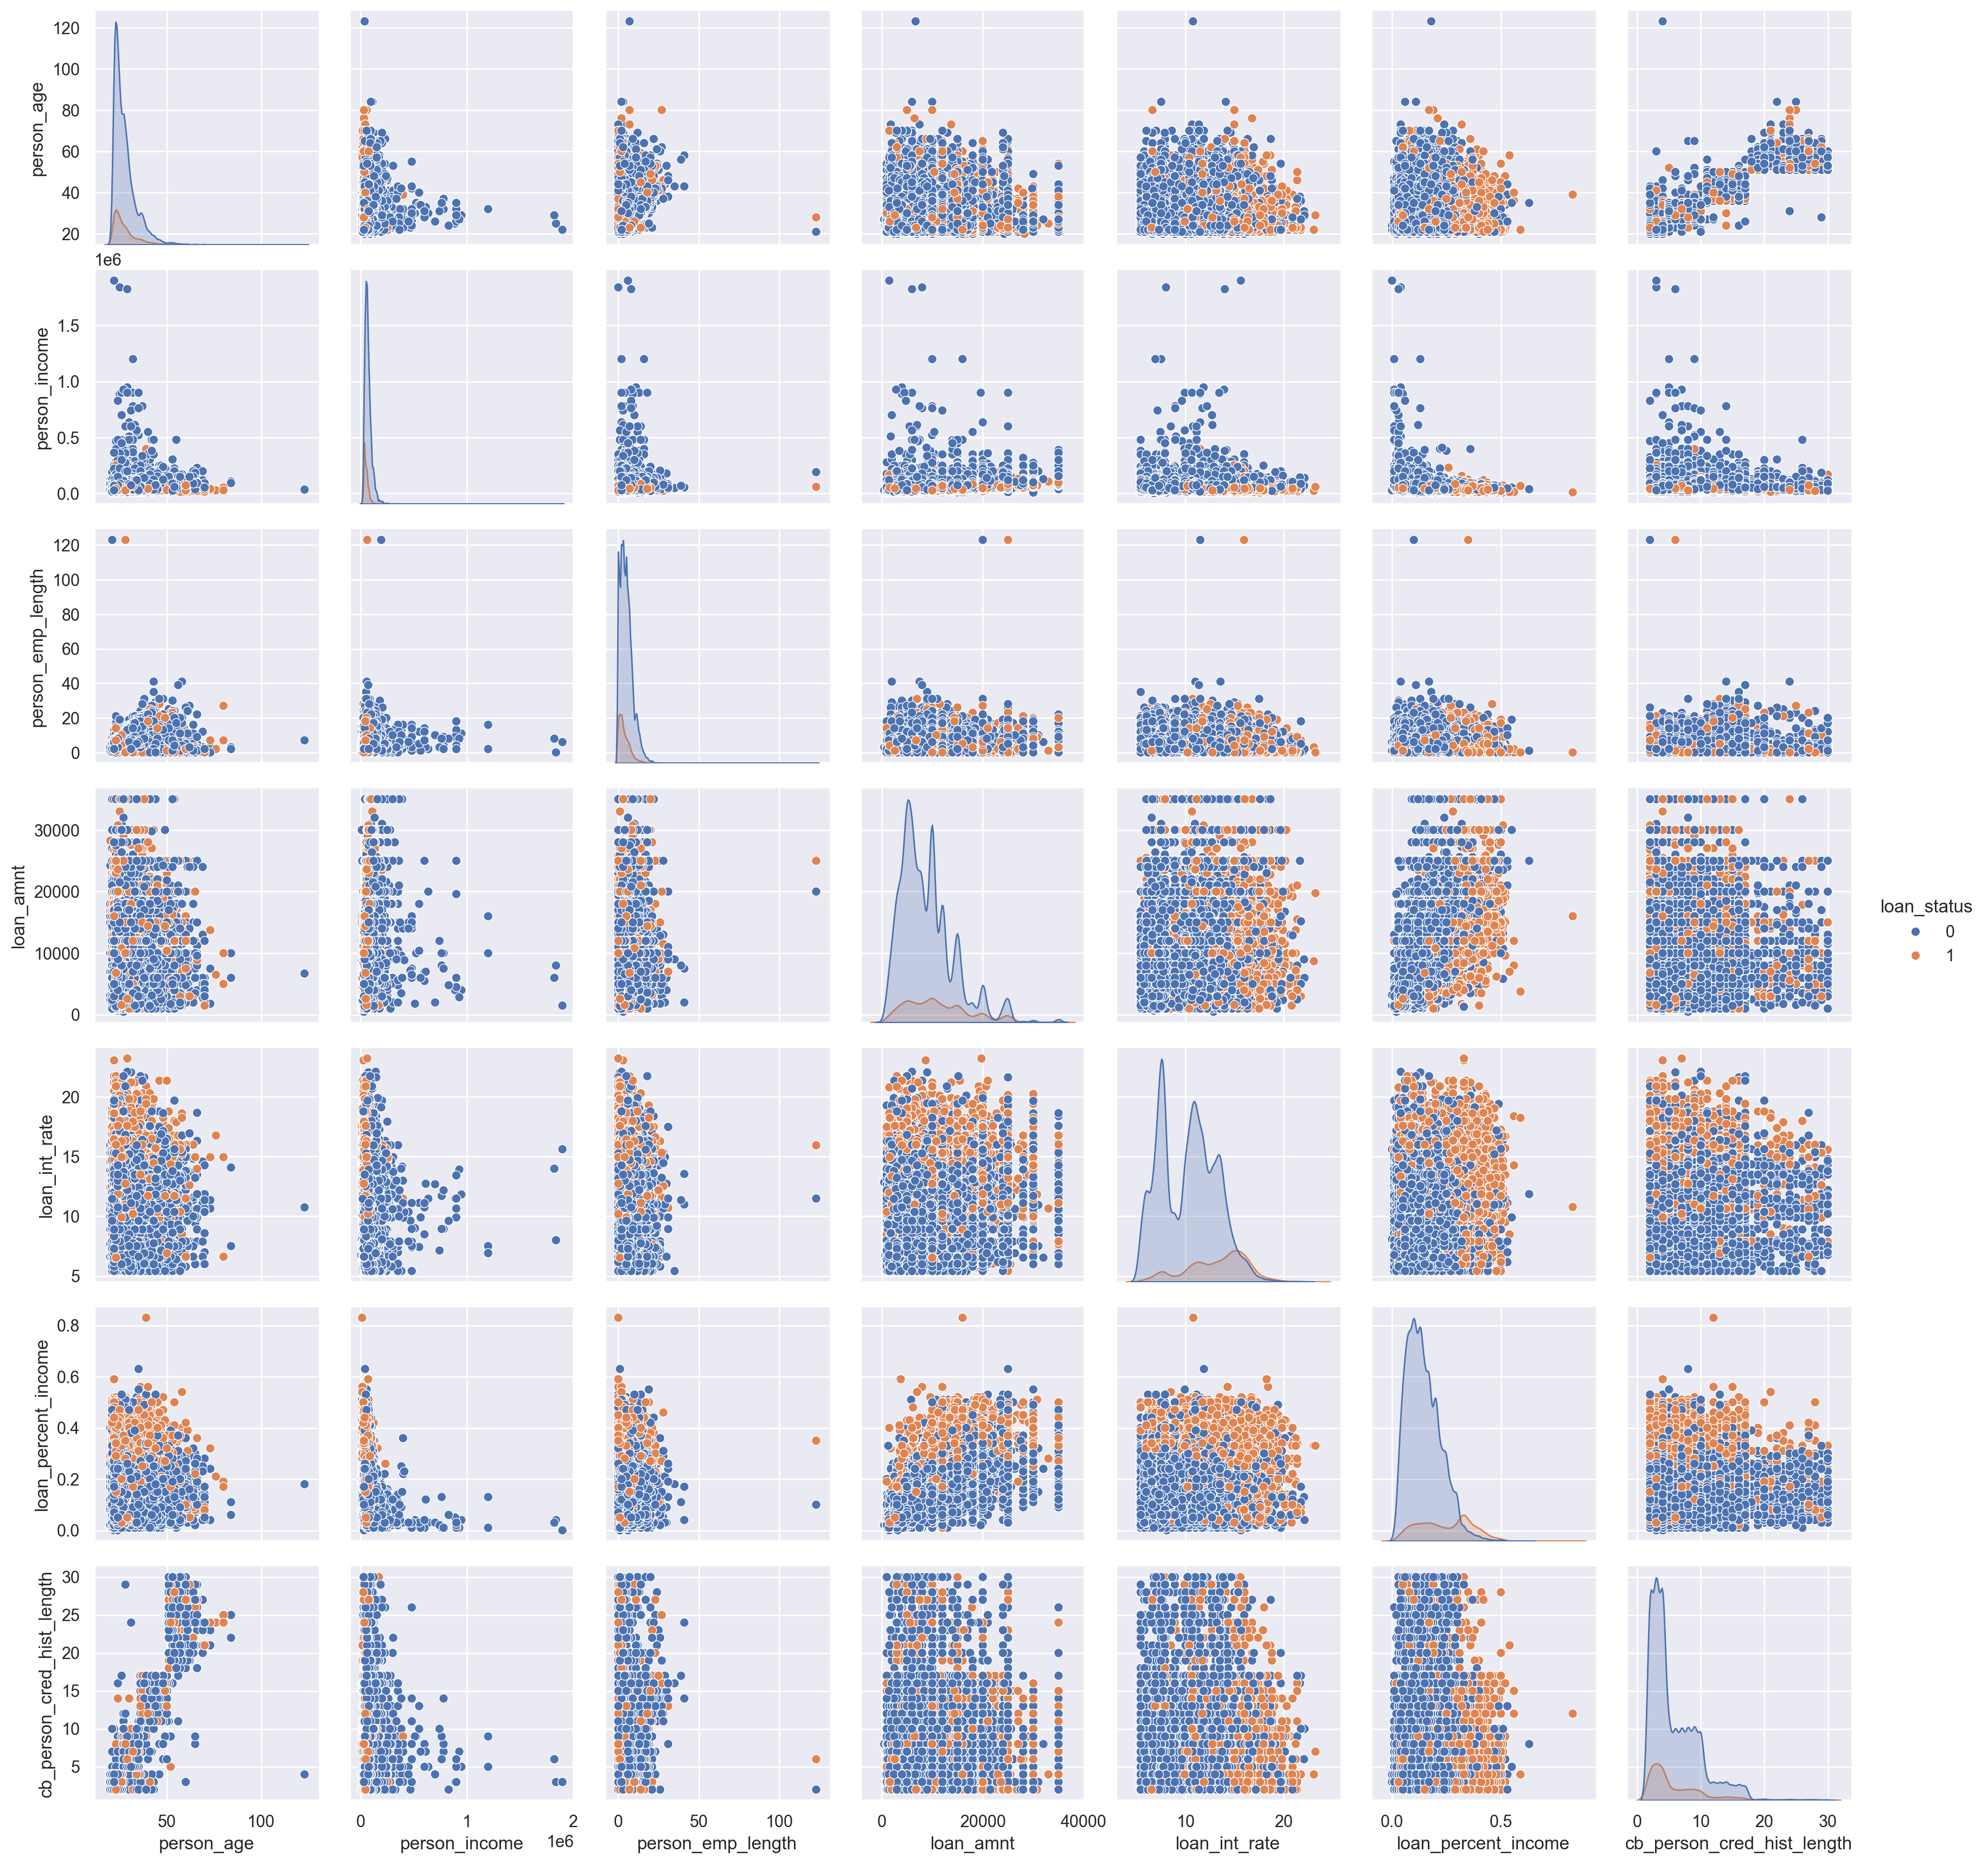

In [16]:
sns.pairplot(train_df, hue='loan_status')

In [16]:
numerical_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

In [17]:
numerical_features.append('loan_status')

In [18]:
numerical_features

['person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'loan_percent_income',
 'cb_person_cred_hist_length',
 'loan_status']

In [19]:
train_df

person_age  person_income person_home_ownership  person_emp_length   
id                                                                          
0              37          35000                  RENT                0.0  \
1              22          56000                   OWN                6.0   
2              29          28800                   OWN                8.0   
3              30          70000                  RENT               14.0   
4              22          60000                  RENT                2.0   
...           ...            ...                   ...                ...   
58640          34         120000              MORTGAGE                5.0   
58641          28          28800                  RENT                0.0   
58642          23          44000                  RENT                7.0   
58643          22          30000                  RENT                2.0   
58644          31          75000              MORTGAGE                2.0   

      loan_intent loan_grade  loan_amnt  loan_int_rate  loan_percent_income   
id                                                                            
0       EDUCATION          B       6000          11.49                 0.17  \
1         MEDICAL          C       4000          13.35                 0.07   
2        PERSONAL          A       6000           8.90                 0.21   
3         VENTURE          B      12000          11.11                 0.17   
4         MEDICAL          A       6000           6.92                 0.10   
...           ...        ...        ...            ...                  ...   
58640   EDUCATION          D      25000          15.95                 0.21   
58641     MEDICAL          C      10000          12.73                 0.35   
58642   EDUCATION          D       6800          16.00                 0.15   
58643   EDUCATION          A       5000           8.90                 0.17   
58644     VENTURE          B      15000          11.11                 0.20   

      cb_person_default_on_file  cb_person_cred_hist_length  loan_status  
id                                                                        
0                             N                          14            0  
1                             N                           2            0  
2                             N                          10            0  
3                             N                           5            0  
4                             N                           3            0  
...                         ...                         ...          ...  
58640                         Y                          10            0  
58641                         N                           8            1  
58642                         N                           2            1  
58643                         N                           3            0  
58644                         N                           5            0  

[58645 rows x 12 columns]

<Axes: >

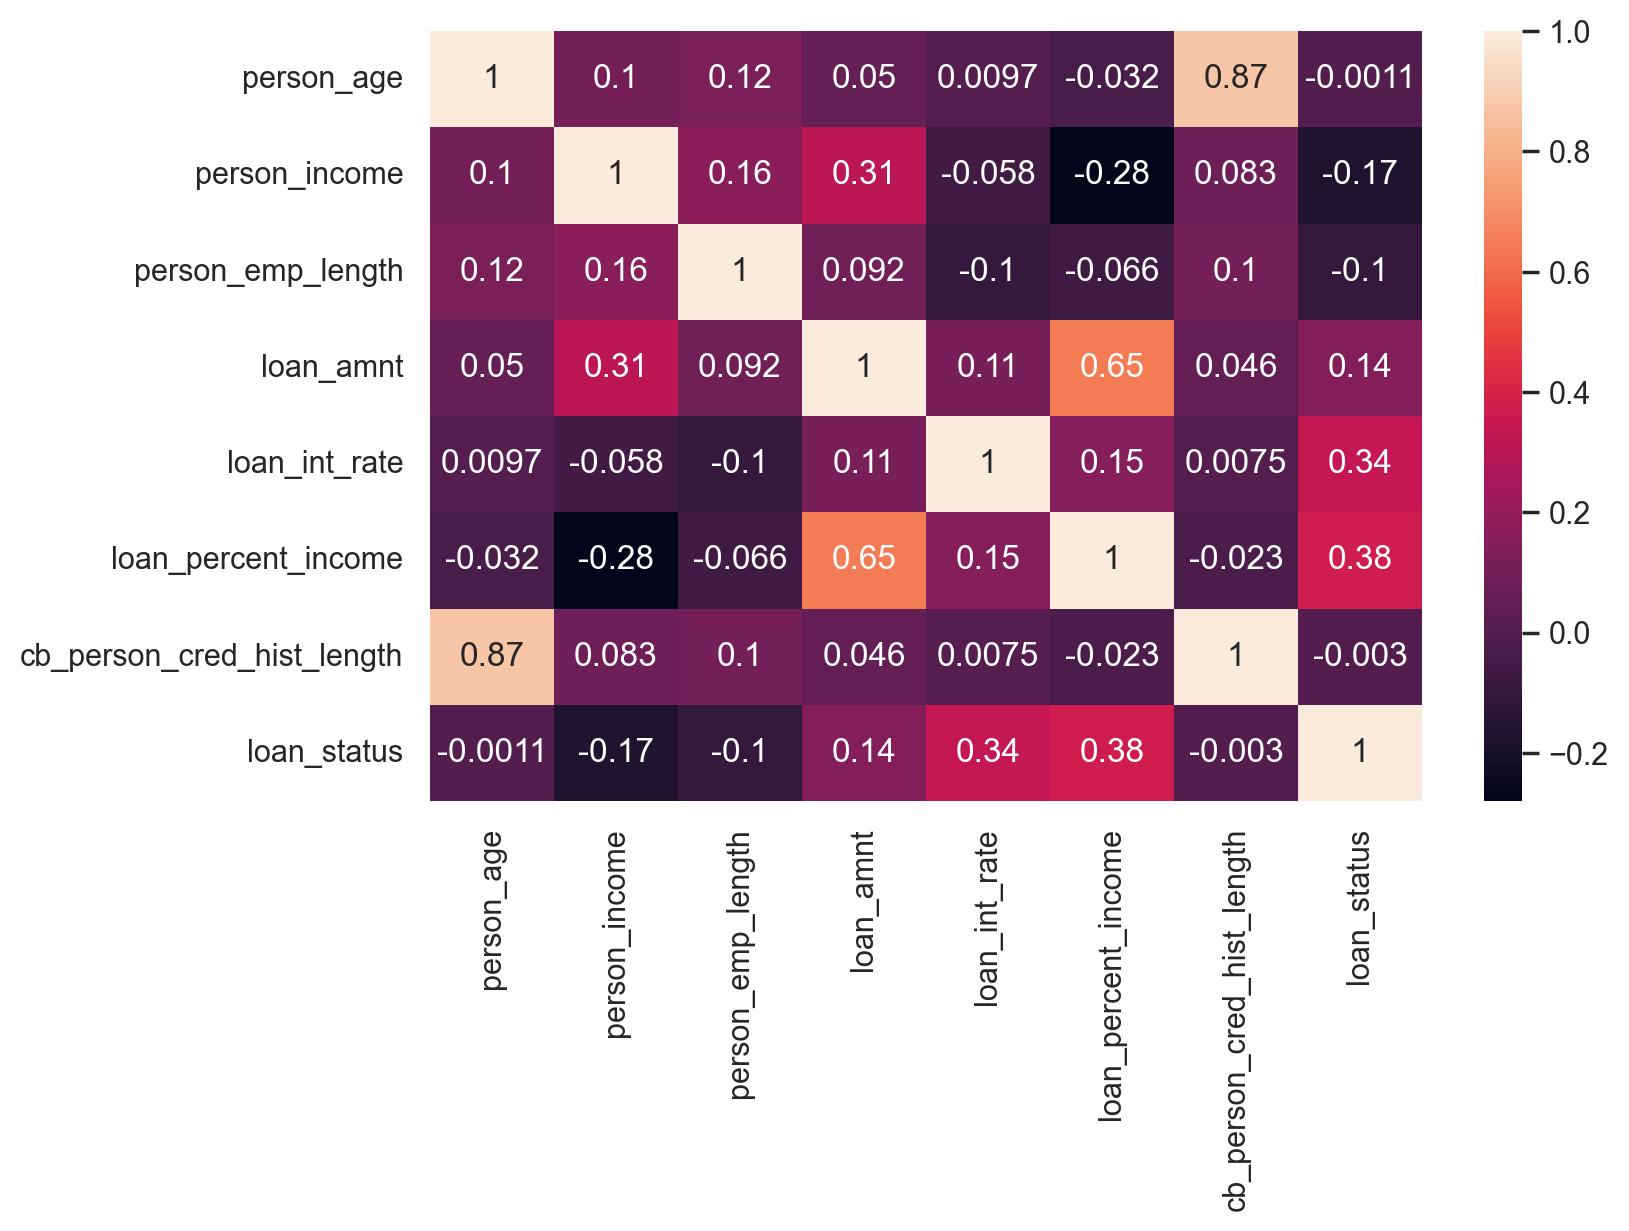

In [20]:
corr_matrix = train_df[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True)

In [21]:
numerical_features.remove('loan_status')

In [22]:
encoder = LabelEncoder()
train_df['loan_grade'] = encoder.fit_transform(train_df['loan_grade'])
train_df

person_age  person_income person_home_ownership  person_emp_length   
id                                                                          
0              37          35000                  RENT                0.0  \
1              22          56000                   OWN                6.0   
2              29          28800                   OWN                8.0   
3              30          70000                  RENT               14.0   
4              22          60000                  RENT                2.0   
...           ...            ...                   ...                ...   
58640          34         120000              MORTGAGE                5.0   
58641          28          28800                  RENT                0.0   
58642          23          44000                  RENT                7.0   
58643          22          30000                  RENT                2.0   
58644          31          75000              MORTGAGE                2.0   

      loan_intent  loan_grade  loan_amnt  loan_int_rate  loan_percent_income   
id                                                                             
0       EDUCATION           1       6000          11.49                 0.17  \
1         MEDICAL           2       4000          13.35                 0.07   
2        PERSONAL           0       6000           8.90                 0.21   
3         VENTURE           1      12000          11.11                 0.17   
4         MEDICAL           0       6000           6.92                 0.10   
...           ...         ...        ...            ...                  ...   
58640   EDUCATION           3      25000          15.95                 0.21   
58641     MEDICAL           2      10000          12.73                 0.35   
58642   EDUCATION           3       6800          16.00                 0.15   
58643   EDUCATION           0       5000           8.90                 0.17   
58644     VENTURE           1      15000          11.11                 0.20   

      cb_person_default_on_file  cb_person_cred_hist_length  loan_status  
id                                                                        
0                             N                          14            0  
1                             N                           2            0  
2                             N                          10            0  
3                             N                           5            0  
4                             N                           3            0  
...                         ...                         ...          ...  
58640                         Y                          10            0  
58641                         N                           8            1  
58642                         N                           2            1  
58643                         N                           3            0  
58644                         N                           5            0  

[58645 rows x 12 columns]

In [23]:
train_df = pd.get_dummies(train_df, drop_first=True)
train_df

person_age  person_income  person_emp_length  loan_grade  loan_amnt   
id                                                                           
0              37          35000                0.0           1       6000  \
1              22          56000                6.0           2       4000   
2              29          28800                8.0           0       6000   
3              30          70000               14.0           1      12000   
4              22          60000                2.0           0       6000   
...           ...            ...                ...         ...        ...   
58640          34         120000                5.0           3      25000   
58641          28          28800                0.0           2      10000   
58642          23          44000                7.0           3       6800   
58643          22          30000                2.0           0       5000   
58644          31          75000                2.0           1      15000   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length   
id                                                                      
0              11.49                 0.17                          14  \
1              13.35                 0.07                           2   
2               8.90                 0.21                          10   
3              11.11                 0.17                           5   
4               6.92                 0.10                           3   
...              ...                  ...                         ...   
58640          15.95                 0.21                          10   
58641          12.73                 0.35                           8   
58642          16.00                 0.15                           2   
58643           8.90                 0.17                           3   
58644          11.11                 0.20                           5   

       loan_status  person_home_ownership_OTHER  person_home_ownership_OWN   
id                                                                           
0                0                        False                      False  \
1                0                        False                       True   
2                0                        False                       True   
3                0                        False                      False   
4                0                        False                      False   
...            ...                          ...                        ...   
58640            0                        False                      False   
58641            1                        False                      False   
58642            1                        False                      False   
58643            0                        False                      False   
58644            0                        False                      False   

       person_home_ownership_RENT  loan_intent_EDUCATION   
id                                                         
0                            True                   True  \
1                           False                  False   
2                           False                  False   
3                            True                  False   
4                            True                  False   
...                           ...                    ...   
58640                       False                   True   
58641                        True                  False   
58642                        True                   True   
58643                        True                   True   
58644                       False                  False   

       loan_intent_HOMEIMPROVEMENT  loan_intent_MEDICAL  loan_intent_PERSONAL   
id                                                                              
0                            False                False                 False  \
1  

In [51]:
def data_preprocessing(df, label_encoder):
    df['loan_grade'] = encoder.transform(df['loan_grade'])
    df = pd.get_dummies(df, drop_first=True)
    print(df)

In [25]:
def add_features(df):
    df['loan_amnt to person_income'] = df['loan_amnt']/df['person_income']
    df['loan_int_rate to loan_amnt'] = df['loan_int_rate']/df['loan_amnt']
    df['loan_int_rate to person_income'] = df['loan_int_rate']/df['person_income']

In [26]:
add_features(train_df)
train_df

person_age  person_income  person_emp_length  loan_grade  loan_amnt   
id                                                                           
0              37          35000                0.0           1       6000  \
1              22          56000                6.0           2       4000   
2              29          28800                8.0           0       6000   
3              30          70000               14.0           1      12000   
4              22          60000                2.0           0       6000   
...           ...            ...                ...         ...        ...   
58640          34         120000                5.0           3      25000   
58641          28          28800                0.0           2      10000   
58642          23          44000                7.0           3       6800   
58643          22          30000                2.0           0       5000   
58644          31          75000                2.0           1      15000   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length   
id                                                                      
0              11.49                 0.17                          14  \
1              13.35                 0.07                           2   
2               8.90                 0.21                          10   
3              11.11                 0.17                           5   
4               6.92                 0.10                           3   
...              ...                  ...                         ...   
58640          15.95                 0.21                          10   
58641          12.73                 0.35                           8   
58642          16.00                 0.15                           2   
58643           8.90                 0.17                           3   
58644          11.11                 0.20                           5   

       loan_status  person_home_ownership_OTHER  ...   
id                                               ...   
0                0                        False  ...  \
1                0                        False  ...   
2                0                        False  ...   
3                0                        False  ...   
4                0                        False  ...   
...            ...                          ...  ...   
58640            0                        False  ...   
58641            1                        False  ...   
58642            1                        False  ...   
58643            0                        False  ...   
58644            0                        False  ...   

       person_home_ownership_RENT  loan_intent_EDUCATION   
id                                                         
0                            True                   True  \
1                           False                  False   
2                           False                  False   
3                            True                  False   
4                            True                  False   
...                           ...                    ...   
58640                       False                   True   
58641                        True                  False   
58642                        True                   True   
58643                        True                   True   
58644                       False                  False   

       loan_intent_HOMEIMPROVEMENT  loan_intent_MEDICAL  loan_intent_PERSONAL   
id                                                                              
0                            False                False                 False  \
1                            False                 True                 False   
2                            False                False                  True   
3                            False                False                 False   
4                            False            

In [27]:
X = train_df.drop('loan_status', axis=1)
y = train_df['loan_status']

In [28]:
X

person_age  person_income  person_emp_length  loan_grade  loan_amnt   
id                                                                           
0              37          35000                0.0           1       6000  \
1              22          56000                6.0           2       4000   
2              29          28800                8.0           0       6000   
3              30          70000               14.0           1      12000   
4              22          60000                2.0           0       6000   
...           ...            ...                ...         ...        ...   
58640          34         120000                5.0           3      25000   
58641          28          28800                0.0           2      10000   
58642          23          44000                7.0           3       6800   
58643          22          30000                2.0           0       5000   
58644          31          75000                2.0           1      15000   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length   
id                                                                      
0              11.49                 0.17                          14  \
1              13.35                 0.07                           2   
2               8.90                 0.21                          10   
3              11.11                 0.17                           5   
4               6.92                 0.10                           3   
...              ...                  ...                         ...   
58640          15.95                 0.21                          10   
58641          12.73                 0.35                           8   
58642          16.00                 0.15                           2   
58643           8.90                 0.17                           3   
58644          11.11                 0.20                           5   

       person_home_ownership_OTHER  person_home_ownership_OWN   
id                                                              
0                            False                      False  \
1                            False                       True   
2                            False                       True   
3                            False                      False   
4                            False                      False   
...                            ...                        ...   
58640                        False                      False   
58641                        False                      False   
58642                        False                      False   
58643                        False                      False   
58644                        False                      False   

       person_home_ownership_RENT  loan_intent_EDUCATION   
id                                                         
0                            True                   True  \
1                           False                  False   
2                           False                  False   
3                            True                  False   
4                            True                  False   
...                           ...                    ...   
58640                       False                   True   
58641                        True                  False   
58642                        True                   True   
58643                        True                   True   
58644                       False                  False   

       loan_intent_HOMEIMPROVEMENT  loan_intent_MEDICAL  loan_intent_PERSONAL   
id                                                                              
0                            False                False                 False  \
1                            False                 True                 False   
2                            False                False                  True   
3         

In [29]:
y

id
0        0
1        0
2        0
3        0
4        0
        ..
58640    0
58641    1
58642    1
58643    0
58644    0
Name: loan_status, Length: 58645, dtype: int64

In [31]:
def objective(trial):
    params = {
        'eval_metric': 'AUC',
        "iterations": trial.suggest_int("iterations", 900, 1100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "random_state": 42,
        "verbose":False,
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = CatBoostClassifier(**params)
        model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=100, verbose=False)
        
        val_preds = model.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val, val_preds)
        scores.append(score)
    
    return np.mean(scores)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

trial = study.best_trial

[I 2024-10-17 03:28:01,726] A new study created in memory with name: no-name-277e8c40-8e01-4cbb-9a79-634d405522cd
[I 2024-10-17 03:28:24,453] Trial 0 finished with value: 0.9334011011677807 and parameters: {'iterations': 945, 'learning_rate': 0.006125622879726446, 'depth': 5, 'subsample': 0.2033330396965622, 'min_data_in_leaf': 32}. Best is trial 0 with value: 0.9334011011677807.
[I 2024-10-17 03:29:08,484] Trial 1 finished with value: 0.9329363581218117 and parameters: {'iterations': 1050, 'learning_rate': 0.0025379840644558053, 'depth': 8, 'subsample': 0.3641850790874666, 'min_data_in_leaf': 16}. Best is trial 0 with value: 0.9334011011677807.
[I 2024-10-17 03:31:01,571] Trial 2 finished with value: 0.9293841663526511 and parameters: {'iterations': 1085, 'learning_rate': 0.0016862824547564422, 'depth': 10, 'subsample': 0.0513373920321196, 'min_data_in_leaf': 50}. Best is trial 0 with value: 0.9334011011677807.
[I 2024-10-17 03:31:07,113] Trial 3 finished with value: 0.906929439659303

[I 2024-10-17 03:46:27,142] Trial 30 finished with value: 0.9483515283777806 and parameters: {'iterations': 1006, 'learning_rate': 0.020826096884979783, 'depth': 5, 'subsample': 0.5364497461747363, 'min_data_in_leaf': 45}. Best is trial 21 with value: 0.9562279318487986.
[I 2024-10-17 03:46:55,647] Trial 31 finished with value: 0.9560706204650051 and parameters: {'iterations': 992, 'learning_rate': 0.07499868349641577, 'depth': 6, 'subsample': 0.6266255776767131, 'min_data_in_leaf': 91}. Best is trial 21 with value: 0.9562279318487986.
[I 2024-10-17 03:47:23,438] Trial 32 finished with value: 0.955833575914083 and parameters: {'iterations': 1055, 'learning_rate': 0.06911903403967116, 'depth': 6, 'subsample': 0.6174402896880313, 'min_data_in_leaf': 90}. Best is trial 21 with value: 0.9562279318487986.
[I 2024-10-17 03:47:56,993] Trial 33 finished with value: 0.9539971890397551 and parameters: {'iterations': 994, 'learning_rate': 0.0364275488328524, 'depth': 7, 'subsample': 0.43867186963

In [32]:
best_params = study.best_params
best_params

{'iterations': 1065,
 'learning_rate': 0.05854525568561321,
 'depth': 6,
 'subsample': 0.8182058357085252,
 'min_data_in_leaf': 67}

In [56]:
test = pd.read_csv('playground-series-s4e10/test.csv', index_col=0)
test

person_age  person_income person_home_ownership  person_emp_length   
id                                                                          
58645          23          69000                  RENT                3.0  \
58646          26          96000              MORTGAGE                6.0   
58647          26          30000                  RENT                5.0   
58648          33          50000                  RENT                4.0   
58649          26         102000              MORTGAGE                8.0   
...           ...            ...                   ...                ...   
97738          22          31200              MORTGAGE                2.0   
97739          22          48000              MORTGAGE                6.0   
97740          51          60000              MORTGAGE                0.0   
97741          22          36000              MORTGAGE                4.0   
97742          31          45000                  RENT                6.0   

             loan_intent loan_grade  loan_amnt  loan_int_rate   
id                                                              
58645    HOMEIMPROVEMENT          F      25000          15.76  \
58646           PERSONAL          C      10000          12.68   
58647            VENTURE          E       4000          17.19   
58648  DEBTCONSOLIDATION          A       7000           8.90   
58649    HOMEIMPROVEMENT          D      15000          16.32   
...                  ...        ...        ...            ...   
97738  DEBTCONSOLIDATION          B       3000          10.37   
97739          EDUCATION          A       7000           6.03   
97740           PERSONAL          A      15000           7.51   
97741           PERSONAL          D      14000          15.62   
97742  DEBTCONSOLIDATION          B      19450           9.91   

       loan_percent_income cb_person_default_on_file   
id                                                     
58645                 0.36                         N  \
58646                 0.10                         Y   
58647                 0.13                         Y   
58648                 0.14                         N   
58649                 0.15                         Y   
...                    ...                       ...   
97738                 0.10                         N   
97739                 0.15                         N   
97740                 0.25                         N   
97741                 0.39                         Y   
97742                 0.44                         N   

       cb_person_cred_hist_length  
id                                 
58645                           2  
58646                           4  
58647                           2  
58648                           7  
58649                           4  
...                           ...  
97738                           4  
97739                           3  
97740                          25  
97741                           4  
97742                           9  

[39098 rows x 11 columns]

In [57]:
test['loan_grade'] = encoder.transform(test['loan_grade'])
test = pd.get_dummies(test, drop_first=True)

In [58]:
test

person_age  person_income  person_emp_length  loan_grade  loan_amnt   
id                                                                           
58645          23          69000                3.0           5      25000  \
58646          26          96000                6.0           2      10000   
58647          26          30000                5.0           4       4000   
58648          33          50000                4.0           0       7000   
58649          26         102000                8.0           3      15000   
...           ...            ...                ...         ...        ...   
97738          22          31200                2.0           1       3000   
97739          22          48000                6.0           0       7000   
97740          51          60000                0.0           0      15000   
97741          22          36000                4.0           3      14000   
97742          31          45000                6.0           1      19450   

       loan_int_rate  loan_percent_income  cb_person_cred_hist_length   
id                                                                      
58645          15.76                 0.36                           2  \
58646          12.68                 0.10                           4   
58647          17.19                 0.13                           2   
58648           8.90                 0.14                           7   
58649          16.32                 0.15                           4   
...              ...                  ...                         ...   
97738          10.37                 0.10                           4   
97739           6.03                 0.15                           3   
97740           7.51                 0.25                          25   
97741          15.62                 0.39                           4   
97742           9.91                 0.44                           9   

       person_home_ownership_OTHER  person_home_ownership_OWN   
id                                                              
58645                        False                      False  \
58646                        False                      False   
58647                        False                      False   
58648                        False                      False   
58649                        False                      False   
...                            ...                        ...   
97738                        False                      False   
97739                        False                      False   
97740                        False                      False   
97741                        False                      False   
97742                        False                      False   

       person_home_ownership_RENT  loan_intent_EDUCATION   
id                                                         
58645                        True                  False  \
58646                       False                  False   
58647                        True                  False   
58648                        True                  False   
58649                       False                  False   
...                           ...                    ...   
97738                       False                  False   
97739                       False                   True   
97740                       False                  False   
97741                       False                  False   
97742                        True                  False   

       loan_intent_HOMEIMPROVEMENT  loan_intent_MEDICAL  loan_intent_PERSONAL   
id                                                                              
58645                         True                False                 False  \
58646                        False                False                  True   
58647                        False                False                 False   
58648     

In [59]:
add_features(test)

In [60]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = []
test_preds = []


for train_idx, val_idx in cv.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = CatBoostClassifier(**best_params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=100, verbose=False)
    
    test_pred = model.predict_proba(test)[:, 1]
    test_preds.append(test_pred)
    
final_test_preds = np.mean(test_preds, axis=0)

In [63]:
submission = pd.DataFrame({
        'id': test.index,
        'loan_status': final_test_preds
    })

In [64]:
submission

id  loan_status
0      58645     0.997607
1      58646     0.018580
2      58647     0.731027
3      58648     0.012900
4      58649     0.076999
...      ...          ...
39093  97738     0.050695
39094  97739     0.004503
39095  97740     0.010959
39096  97741     0.199633
39097  97742     0.953593

[39098 rows x 2 columns]

In [65]:
#score: 0.96092
submission.to_csv('submission.csv', index=False)